In [1]:
import itertools
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from qiskit import Aer, IBMQ, QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.circuit.library import FermionicGaussianState
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.operators.second_quantization import FermionicOp, QuadraticHamiltonian
from mzm_generation import (
    bdg_hamiltonian,
    compute_measure_edge_correlation,
    compute_measure_hamiltonian,
    edge_correlation_op,
    expectation,
    kitaev_hamiltonian,
    run_job)

In [2]:
# boilerplate
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
# hardware_backend = provider.get_backend('ibmq_manila')
simulator_backend = Aer.get_backend("statevector_simulator")
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper)

In [3]:
# set parameters

# number of modes
n_modes = 3

# number of x values
num = 20

# backend
backend = simulator_backend

# number of shots
shots = 10000

/home/kjs/projects/qiskit-research-reviews/mzm-generation/mzm_generation.py:21: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(f"-_{index}") + FermionicOp(f"+_{index}")


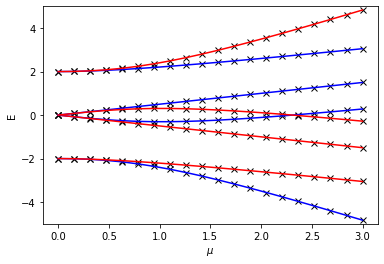

In [4]:
# generate Hamiltonians and compute simulation values
x_values = np.linspace(1e-7, 3, num=num)
hamiltonians = []
energy_shifts = []

exact_series = np.zeros((num, 2**n_modes))
gaussian_even_series = np.zeros((num, 2**(n_modes - 1)))
gaussian_odd_series = np.zeros((num, 2**(n_modes - 1)))
edge_corr_exact_even_series = np.zeros((num, 2**(n_modes - 1)))
edge_corr_exact_odd_series = np.zeros((num, 2**(n_modes - 1)))

edge_correlation = edge_correlation_op(n_modes)
edge_correlation_jw = converter.convert(edge_correlation)
edge_correlation_dense = edge_correlation_jw.to_matrix()

for i, chemical_potential in enumerate(x_values):
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=-1.0,
        superconducting=1.0,
        chemical_potential=chemical_potential)
    hamiltonians.append(hamiltonian_quad)
    # compute eigenvalues
    hamiltonian = hamiltonian_quad._fermionic_op()
    hamiltonian_jw = converter.convert(hamiltonian).primitive
    hamiltonian_dense = hamiltonian_jw.to_matrix()
    eigs, _ = np.linalg.eigh(hamiltonian_dense)
    # shift eigenvalues to make them symmetric about 0
    energy_shift = -0.5 * (eigs[0] + eigs[-1])
    energy_shifts.append(energy_shift)
    exact_series[i] = eigs + energy_shift
    # compute properties of Gaussian states
    even_energies = []
    odd_energies = []
    even_correlations = []
    odd_correlations = []
    for n_particles in range(n_modes + 1):
        energy_list = odd_energies if n_particles % 2 else even_energies
        correlation_list = odd_correlations if n_particles % 2 else even_correlations
        for occupied_orbitals in itertools.combinations(range(n_modes), n_particles):
            transformation_matrix, _, _ = hamiltonian_quad.diagonalizing_bogoliubov_transform()
            circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals)
            state = simulator_backend.run(circuit.decompose()).result().get_statevector().data
            energy_list.append(np.real(expectation(hamiltonian_dense, state)) + energy_shift)
            correlation_list.append(np.real(expectation(edge_correlation_dense, state)))
    gaussian_even_series[i] = even_energies
    gaussian_odd_series[i] = odd_energies
    edge_corr_exact_even_series[i] = even_correlations
    edge_corr_exact_odd_series[i] = odd_correlations

# plot
fig, ax = plt.subplots()

for i in range(2**n_modes):
    ax.plot(x_values, exact_series[:, i], 'x', color='black')
for i in range(2**(n_modes - 1)):
    ax.plot(x_values, gaussian_even_series[:, i], color='blue')
    ax.plot(x_values, gaussian_odd_series[:, i], color='red')

ax.set_xlabel(r'$\mu$')
ax.set_ylabel('E')
ax.set_ylim(-5, 5)
plt.show()

In [5]:
# run jobs
jobs = {}

for i, hamiltonian_quad in enumerate(hamiltonians):
    hamiltonian = hamiltonian_quad._fermionic_op()
    for n_particles in range(n_modes + 1):
        for occupied_orbitals in itertools.combinations(range(n_modes), n_particles):
            transformation_matrix, _, _ = hamiltonian_quad.diagonalizing_bogoliubov_transform()
            circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals)
            jobs[(i, occupied_orbitals)] = run_job(backend, circuit, shots)

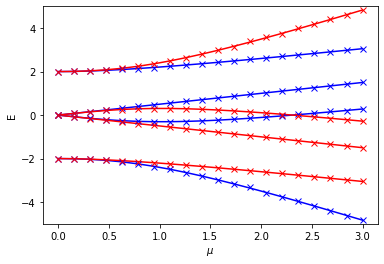

In [6]:
# analyze results for Hamiltonian expectation
experiment_even_series = np.zeros((num, 2**(n_modes - 1)))
experiment_odd_series = np.zeros((num, 2**(n_modes - 1)))

for i, (hamiltonian_quad, energy_shift) in enumerate(
        zip(hamiltonians, energy_shifts)):
    hamiltonian = hamiltonian_quad._fermionic_op()
    hamiltonian_jw = converter.convert(hamiltonian).primitive
    even_energies = []
    odd_energies = []
    for n_particles in range(n_modes + 1):
        energy_list = odd_energies if n_particles % 2 else even_energies
        for occupied_orbitals in itertools.combinations(range(n_modes), n_particles):
            job = jobs[(i, occupied_orbitals)]
            energy = compute_measure_hamiltonian(job, hamiltonian_jw)
            energy_list.append(energy + energy_shift)
    experiment_even_series[i] = even_energies
    experiment_odd_series[i] = odd_energies

# plot
fig, ax = plt.subplots()

for i in range(2**(n_modes - 1)):
    ax.plot(x_values, gaussian_even_series[:, i], color='blue')
    ax.plot(x_values, gaussian_odd_series[:, i], color='red')
for i in range(2**(n_modes - 1)):
    ax.plot(x_values, experiment_even_series[:, i], 'x', color='blue')
    ax.plot(x_values, experiment_odd_series[:, i], 'x', color='red')

ax.set_xlabel(r'$\mu$')
ax.set_ylabel('E')
ax.set_ylim(-5, 5)
plt.show()

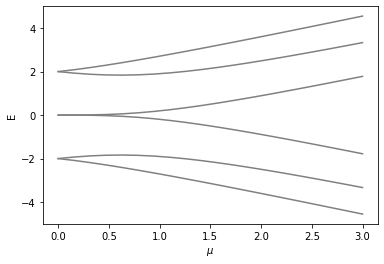

In [7]:
# compute BdG Hamiltonian eigenvalues
bdg_series = np.zeros((num, 2 * n_modes))

for i, hamiltonian_quad in enumerate(hamiltonians):
    hamiltonian_bdg = bdg_hamiltonian(hamiltonian_quad)
    eigs, _ = np.linalg.eigh(hamiltonian_bdg)
    bdg_series[i] = eigs
    
# plot
fig, ax = plt.subplots()

for i in range(2 * n_modes):
    ax.plot(x_values, bdg_series[:, i], color='gray')

ax.set_xlabel(r'$\mu$')
ax.set_ylabel('E')
ax.set_ylim(-5, 5)
plt.show()

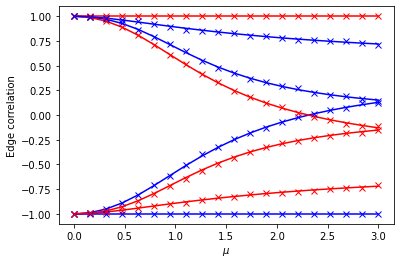

In [8]:
# analyze results for edge correlation
edge_corr_experiment_even_series = np.zeros((num, 2**(n_modes - 1)))
edge_corr_experiment_odd_series = np.zeros((num, 2**(n_modes - 1)))

for i, hamiltonian_quad in enumerate(hamiltonians):
    even_correlations = []
    odd_correlations = []
    for n_particles in range(n_modes + 1):
        correlation_list = odd_correlations if n_particles % 2 else even_correlations
        for occupied_orbitals in itertools.combinations(range(n_modes), n_particles):
            job = jobs[(i, occupied_orbitals)]
            experiment_correlation = compute_measure_edge_correlation(job)
            correlation_list.append(experiment_correlation)
    edge_corr_experiment_even_series[i] = even_correlations
    edge_corr_experiment_odd_series[i] = odd_correlations

# plot
fig, ax = plt.subplots()

for i in range(2**(n_modes - 1)):
    ax.plot(x_values, edge_corr_exact_even_series[:, i], color='blue')
    ax.plot(x_values, edge_corr_exact_odd_series[:, i], color='red')
for i in range(2**(n_modes - 1)):
    ax.plot(x_values, edge_corr_experiment_even_series[:, i], 'x', color='blue')
    ax.plot(x_values, edge_corr_experiment_odd_series[:, i], 'x', color='red')

ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Edge correlation')
ax.set_ylim(-1.1, 1.1)
plt.show()